# Lane data analysis

### Import Libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from tqdm import tqdm

from os import path
import gc

# RAPIDS / cuML imports
from cuml.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from cuml.ensemble import RandomForestClassifier
from cuml.ensemble import RandomForestRegressor
from cuml.linear_model import LogisticRegression
from cuml.linear_model import LinearRegression
from cuml.neighbors import KNeighborsClassifier
from cuml.neighbors import KNeighborsRegressor

import cupy as cp  # GPU array backend

### Import dataset

In [25]:
file_name, experiment_name = "lane_data.csv", "rush_hour"
file_path = path.join("..", "..", "data", experiment_name, file_name)

df = pd.read_csv(file_path, engine="pyarrow")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   step           36000 non-null  int64  
 1   time           36000 non-null  float64
 2   lane_id        36000 non-null  object 
 3   occupancy      36000 non-null  float64
 4   density        36000 non-null  float64
 5   vehicle_count  36000 non-null  int64  
 6   mean_speed     36000 non-null  float64
 7   waiting_time   36000 non-null  float64
 8   queue_length   36000 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 2.5+ MB


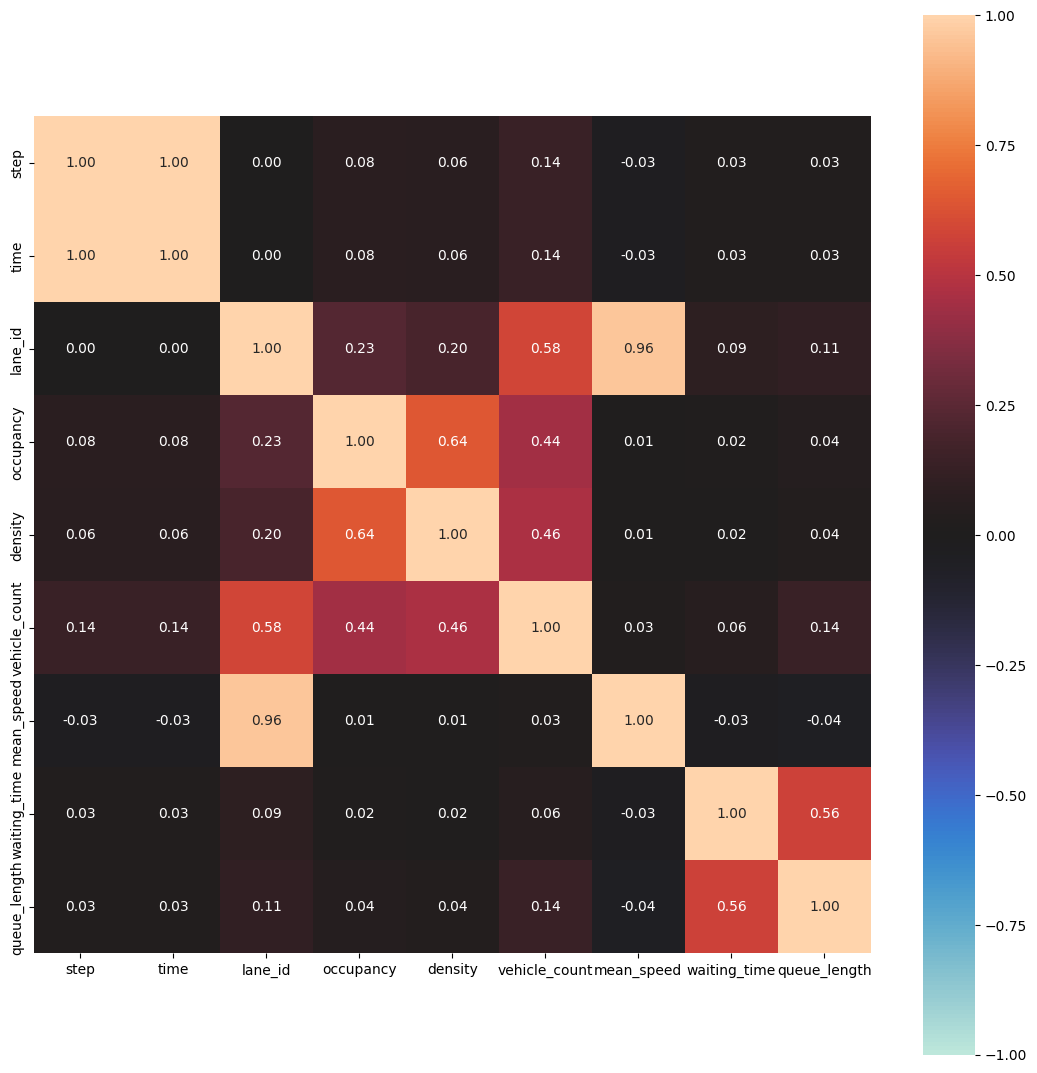

Detected task type: regressor


Evaluating GPU models: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Top GPU models:
RandomForestRegressor          0.9996
KNeighborsRegressor            0.4666
LinearRegression               0.1405


In [26]:
# Quick associations heatmap
associations(df, plot=True)

# Encode categoricals for GPU
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    # Fit on the CPU first
    cpu_vals = df[col].astype(str).values  # ensure everything is string
    le.fit(cpu_vals)
    # Transform and move to GPU
    df[col] = le.transform(cpu_vals)

# =========================
# Define target
# =========================
target_var = "mean_speed"
X = df.drop(columns=[target_var])
y = df[target_var]

# Detect task type (classifier vs regressor)
if y.dtypes == 'object' or len(np.unique(y)) < 15:
    task = 'classifier'
else:
    task = 'regressor'
print(f"Detected task type: {task}")

# =========================
# Train/test split (GPU)
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    cp.asarray(X.values), cp.asarray(y.values), test_size=0.2, random_state=42
)

# =========================
# Map of ML estimators
# =========================
if task == 'classifier':
    estimators = {
        'LogisticRegression': LogisticRegression(),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=100),
        'KNeighborsClassifier': KNeighborsClassifier(),
    }
else:
    estimators = {
        'LinearRegression': LinearRegression(),
        'RandomForestRegressor': RandomForestRegressor(n_estimators=100),
        'KNeighborsRegressor': KNeighborsRegressor(),
    }

# =========================
# Simple GPU CV
# =========================
def simple_cv(model, X, y, folds=3):
    n_samples = X.shape[0]
    indices = cp.arange(n_samples)
    cp.random.shuffle(indices)
    fold_size = n_samples // folds
    scores = []

    for i in range(folds):
        val_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = cp.concatenate([indices[:i*fold_size], indices[(i+1)*fold_size:]])
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model.fit(X_tr, y_tr)
        score = model.score(X_val, y_val)
        scores.append(score)
    return cp.mean(cp.array(scores)).get()  # move back to CPU for printing

# =========================
# Evaluate models
# =========================
results = []
for name, model in tqdm(estimators.items(), desc="Evaluating GPU models"):
    try:
        score = simple_cv(model, X_train, y_train, folds=3)
        results.append((name, score))
        gc.collect()
    except Exception as e:
        print(f"Skipping {name}: {e}")

# =========================
# Sort & show results
# =========================
results = sorted(results, key=lambda x: x[1], reverse=True)
print("\nTop GPU models:")
for name, score in results[:10]:
    print(f"{name:30s} {score:.4f}")